In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

In [2]:
def ft_inches_to_total_inches(x):
    ft_inches_str = (x.str.split(' / ', expand=True)[0]
                 .str.strip()
                 .str.replace('½', '.5')
                )
    pat = r'(?P<feet>\d+)′ (?P<inches>\d+\.?\d?)″'
    ft_inch_columns = ft_inches_str.str.extract(pat).astype('float64')
    inches = (ft_inch_columns.loc[:, 'feet'] * 12 + ft_inch_columns.loc[:, 'inches']).rename('opponent_height_in_inches')
    return inches

def join_opponent_height_in_inches(input_df):
    df = input_df.copy()
    df = df.join(ft_inches_to_total_inches(df.opponent_height))
    return df

In [8]:
df.loc[~df.opponent_reach.str.replace('½', ".5").str.match(r'\d+\.?\d?″ / .*', na=True), ]

,name,fight_id,opponent_name,opponent_ranking,opponent_before fight,opponent_after fight,opponent_age,opponent_stance,opponent_height,opponent_reach,opponent_won,opponent_lost,opponent_drawn,opponent_KOs,opponent_ruling,opponent_result,winner,date,url,win,loss,draw,ruling,ending_round,early_stoppage,opponent_height_in_inches


In [18]:
fin = r'data\FuryWilderFightHistory.xlsx'
df = (pd.read_excel(fin)
      .assign(date=lambda x: pd.to_datetime(x.date, format='%A %d, %B %Y'),
              win=lambda x: (x.winner == x.name) * 1,
              loss=lambda x:  ((x.winner != x.name) & (~x.winner.isna())) * 1,
              draw=lambda x: x.winner.isna() * 1,
              ruling=lambda x: x.opponent_ruling.str.split(expand=True)[0],
              ending_round=lambda x: x.opponent_ruling.str.split(expand=True)[2].fillna(12).astype(int),
              early_stoppage=lambda x: x.ruling.isin(['TKO', 'RTD', 'KO']) * 1,
              opponent_reach_in_inches=lambda x: x.opponent_reach.str.replace('½', ".5").str.extract(r'(\d+\.?\d?)″ / .*').astype('float64'),
             )
      .pipe(join_opponent_height_in_inches)
      .drop(['opponent_last 6'], axis=1)
     )

In [82]:
df.head()

,name,fight_id,opponent_name,opponent_ranking,opponent_before fight,opponent_after fight,opponent_age,opponent_stance,opponent_height,opponent_reach,opponent_won,opponent_lost,opponent_drawn,opponent_KOs,opponent_ruling,opponent_result,winner,date,url,win,loss,draw,ruling,ending_round,early_stoppage,opponent_height_in_inches
0,Tyson Fury,2424982,Deontay Wilder,5.0,756.3 points,481.3 points,34.0,orthodox,6′ 7″ / 201cm,83″ / 211cm,42,0,1,41,TKO round 7,loss,Tyson Fury,2020-02-22,https://boxrec.com/en/event/798948/2424982,1,0,0,TKO,7,1,79.0
1,Tyson Fury,2380608,Otto Wallin,59.0,42.80 points,42.80 points,28.0,southpaw,6′ 5½″ / 197cm,78″ / 198cm,20,0,0,13,UD round 12,loss,Tyson Fury,2019-09-14,https://boxrec.com/en/event/793512/2380608,1,0,0,UD,12,0,77.5
2,Tyson Fury,2335845,Tom Schwarz,60.0,27.80 points,27.80 points,25.0,orthodox,6′ 5½″ / 197cm,NaN,24,0,0,16,TKO round 2,loss,Tyson Fury,2019-06-15,https://boxrec.com/en/event/784993/2335845,1,0,0,TKO,2,1,77.5
3,Tyson Fury,2281110,Deontay Wilder,5.0,635.7 points,557.7 points,33.0,orthodox,6′ 7″ / 201cm,83″ / 211cm,40,0,0,39,SD,draw,NaN,2018-12-01,https://boxrec.com/en/event/775415/2281110,0,0,1,SD,12,0,79.0
4,Tyson Fury,2256926,Francesco Pianeta,NaN,23.44 points,23.44 points,33.0,southpaw,6′ 5″ / 196cm,80″ / 203cm,35,4,1,21,PTS round 10,loss,Tyson Fury,2018-08-18,https://boxrec.com/en/event/769039/2256926,1,0,0,PTS,10,0,77.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75 entries, 0 to 74
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   name                   75 non-null     object        
 1   fight_id               75 non-null     int64         
 2   opponent_name          75 non-null     object        
 3   opponent_ranking       27 non-null     float64       
 4   opponent_before fight  75 non-null     object        
 5   opponent_after fight   75 non-null     object        
 6   opponent_age           74 non-null     float64       
 7   opponent_stance        65 non-null     object        
 8   opponent_height        65 non-null     object        
 9   opponent_reach         34 non-null     object        
 10  opponent_won           75 non-null     int64         
 11  opponent_lost          75 non-null     int64         
 12  opponent_drawn         75 non-null     int64         
 13  opponen

In [6]:
""" Summary Statistics """
(df.rename(columns={'name': 'Name'})
 .groupby(['Name']).agg(
    min_date=pd.NamedAgg(column='date', aggfunc='min'),
    max_date=pd.NamedAgg(column='date', aggfunc='max'),
    total_fights=pd.NamedAgg(column='Name', aggfunc='count'),
    wins=pd.NamedAgg(column='win', aggfunc='sum'),
    losses=pd.NamedAgg(column='loss', aggfunc='sum'),
    draws=pd.NamedAgg(column='draw', aggfunc='sum'),
    early_stoppages=pd.NamedAgg(column='early_stoppage', aggfunc='sum'),
    average_ending_round=pd.NamedAgg(column='ending_round', aggfunc='mean'),
    average_opponent_ranking=pd.NamedAgg(column='opponent_ranking', aggfunc='mean'),
    average_opponent_wins=pd.NamedAgg(column='opponent_won', aggfunc='mean'),
    average_opponent_losses=pd.NamedAgg(column='opponent_lost', aggfunc='mean'),
    average_opponent_draws=pd.NamedAgg(column='opponent_drawn', aggfunc='mean'),
    average_opponent_kos=pd.NamedAgg(column='opponent_KOs', aggfunc='mean'),
 )
 .assign(
     min_date=lambda x: x.min_date.dt.strftime('%A %d, %B %Y'),
     max_date=lambda x: x.max_date.dt.strftime('%A %d, %B %Y'),
     average_ending_round=lambda x: x.average_ending_round.round(2),
     average_opponent_kos=lambda x: x.average_opponent_kos.round(2),
     earl_stoppage_percentage=lambda x: (x.early_stoppages / x.total_fights).map('{:0.2%}'.format),
 )
 .rename(columns={
     'min_date': 'First Professional Fight',
     'max_date': 'Most Recent Professional Fight',
     'total_fights': 'Total Fights',
     'wins': 'Wins',
     'losses': 'Losses',
     'draws': 'Draws',
     'early_stoppages': 'Early Stoppages',
     'average_ending_round': 'Average Ending Round',
     'average_opponent_ranking': 'Average Opponent\'s Ranking',
     'average_opponent_wins': 'Average Opponent\'s Number of Wins',
     'average_opponent_losses': 'Average Opponent\'s Number of Losses',
     'average_opponent_draws': 'Average Opponent\'s Number of Draws',
     'average_opponent_kos': 'Average Opponent\'s Total KOs',
     'earl_stoppage_percentage': 'Early Stoppage %',
 })
 .T
)

Name,Deontay Wilder,Tyson Fury
First Professional Fight,"Saturday 15, November 2008","Saturday 06, December 2008"
Most Recent Professional Fight,"Saturday 22, February 2020","Saturday 22, February 2020"
Total Fights,44,31
Wins,42,30
Losses,1,0
Draws,1,1
Early Stoppages,42,21
Average Ending Round,3.41,6.23
Average Opponent's Ranking,155.286,136
Average Opponent's Number of Wins,17.3636,21.6129


### Notes

* Both started at almost exactly the same time
* Wilder has fought more
* The only loss between them was when Fury beat Wilder in February
* Wilder finishes opponents in almost half the time and has a higher early stoppage percentage
* Fury opponents are slightly better than Wilders (more wins and average lower ranked)

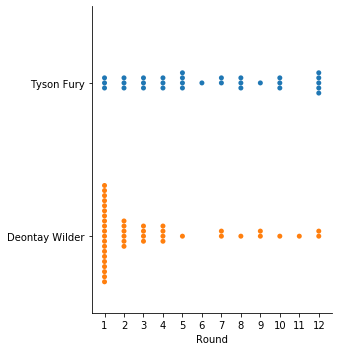

In [7]:
ax = sns.catplot(x='ending_round', y='name', data=df, kind="swarm")
ax.set(xlabel='Round', ylabel='')
plt.xticks(range(1, 13), range(1, 13))
plt.show()

In [8]:
""" 
Deontay Wilder Fights gone on longer as time goes on 
Fury has a similar pattern but not as extreme
"""
(df
 .assign(
     year=lambda x: x.date.dt.year
 )
 .groupby(['name', 'ending_round', 'year']).size()
 .unstack('year')
 .fillna(0)
 .applymap(int)
 .style
 .background_gradient(cmap='Blues', axis=None)
)

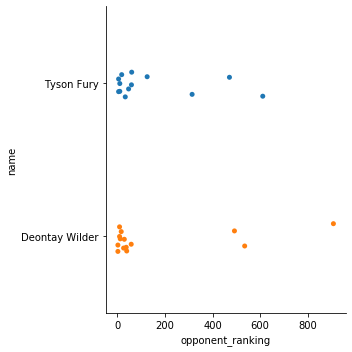

In [9]:
sns.catplot(x='opponent_ranking', y='name', data=df)

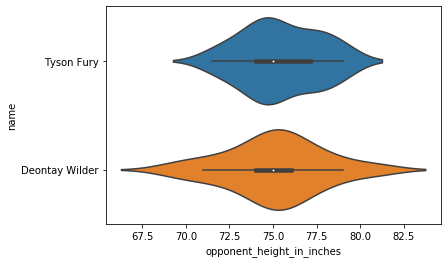

In [86]:
"""
More dispersion in fighter heights for Wilder
The two biggest fighters are Fury!

"""
sns.violinplot(x='opponent_height_in_inches', y='name', data=df)

In [95]:
"""
Fury has only fought one fight below six feet
Matthew Ellis is a brave dude!
"""
fury_mask = df.name == 'Tyson Fury'
(df.loc[fury_mask, ]
 .nsmallest(1, 'opponent_height_in_inches')
 .loc[:, ['opponent_name', 'opponent_height']]
 .set_index('opponent_name')
)

,opponent_height
opponent_name,
Mathew Ellis,5′ 11½″ / 182cm


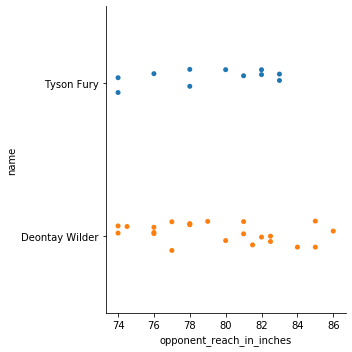

In [38]:
"""
Simliar disribution except Wild has fought fighters with longer reaches (Fury is two of those fights!)
"""
sns.catplot(x='opponent_reach_in_inches', y='name', data=df)
plt.show()

In [37]:
""" Fighters with the three longest reaches! """
(df.loc[:, ['opponent_name', 'opponent_reach_in_inches']]
 .drop_duplicates()
 .nlargest(3, 'opponent_reach_in_inches')
)

,opponent_name,opponent_reach_in_inches
47,Audley Harrison,86.0
31,Tyson Fury,85.0
62,Harold Sconiers,84.0


In [10]:
""" Let's check out the not ranked list """
mask = (df.opponent_ranking > 200) | (df.opponent_ranking.isna())
columns = ['name', 'opponent_name', 'date', 'opponent_ranking']
by = ['name', 'date']
(df.loc[mask, columns].sort_values(by)
 .assign(opponent_ranking=lambda x: x.opponent_ranking.apply(lambda rank: int(rank) if rank == rank else 'Not Ranked'))
 .set_index(['name', 'opponent_name', 'date'])
)

opponent_ranking
name           opponent_name       date                       
Deontay Wilder Ethan Cox           2008-11-15       Not Ranked
               Shannon Gray        2009-03-06       Not Ranked
               Richard Greene Jr   2009-03-14       Not Ranked
               Joseph Rabotte      2009-04-24       Not Ranked
               Charles Brown       2009-05-23       Not Ranked
               Kelsey Arnold       2009-06-26       Not Ranked
               Travis Allen        2009-08-14       Not Ranked
               Jerry Vaughn        2009-11-28       Not Ranked
               Ty Cobb             2010-04-02       Not Ranked
               Alvaro Morales      2010-04-30       Not Ranked
               Dustin Nichols      2010-07-03              908
               Shannon Caudle      2010-09-25       Not Ranked
               Harold Sconiers     2010-10-15       Not Ranked
               Dan Sheehan         2010-12-02       Not Ranked
               DeAndrey Abron      2011-02-19       Not Ranked
               Reggie Pena         2011-05-06       Not Ranked
               Damon Reed          2011-06-18       Not Ranked
               Dominique Alexander 2011-08-27       Not Ranked
               Daniel Cota         2011-11-05              535
               David Long          2011-11-26       Not Ranked
               Marlon Hayes        2012-02-25       Not Ranked
               Jesse Oltmanns      2012-05-26       Not Ranked
               Owen Beck           2012-06-23       Not Ranked
               Kertson Manswell    2012-08-04       Not Ranked
               Damon McCreary      2012-09-08       Not Ranked
               Kelvin Price        2012-12-15       Not Ranked
               Matthew Greer       2013-01-19              492
               Audley Harrison     2013-04-27       Not Ranked
               Nicolai Firtha      2013-10-26       Not Ranked
               Malik Scott         2014-03-15       Not Ranked
               Jason Gavern        2014-08-16       Not Ranked
               Bermane Stiverne    2015-01-17       Not Ranked
                                   2017-11-04       Not Ranked
Tyson Fury     Bela Gyongyosi      2008-12-06       Not Ranked
               Marcel Zeller       2009-01-17       Not Ranked
               Daniil Peretyatko   2009-02-28       Not Ranked
               Lee Swaby           2009-03-14       Not Ranked
               Mathew Ellis        2009-04-11       Not Ranked
               Scott Belshaw       2009-05-23              471
               Aleksandrs Selezens 2009-07-18       Not Ranked
               John McDermott      2009-09-11       Not Ranked
               Tomas Mrazek        2009-09-26              611
               Hans-Joerg Blasko   2010-03-05       Not Ranked
               John McDermott      2010-06-25       Not Ranked
               Rich Power          2010-09-10       Not Ranked
               Zack Page           2010-12-18       Not Ranked
               Marcelo Nascimento  2011-02-19              314
               Nicolai Firtha      2011-09-17       Not Ranked
               Neven Pajkic        2011-11-12       Not Ranked
               Martin Rogan        2012-04-14       Not Ranked
               Vinny Maddalone     2012-07-07       Not Ranked
               Steve Cunningham    2013-04-20       Not Ranked
               Wladimir Klitschko  2015-11-28       Not Ranked
               Francesco Pianeta   2018-08-18       Not Ranked

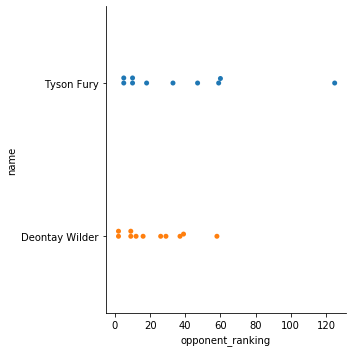

In [11]:
sns.catplot(x='opponent_ranking', y='name', data=df.loc[~mask, ], kind='swarm')

C:\Users\Brendan Non-Admin\Anaconda3\lib\site-packages\seaborn\categorical.py:1324: RuntimeWarning: invalid value encountered in less
  off_low = points < low_gutter
C:\Users\Brendan Non-Admin\Anaconda3\lib\site-packages\seaborn\categorical.py:1328: RuntimeWarning: invalid value encountered in greater
  off_high = points > high_gutter


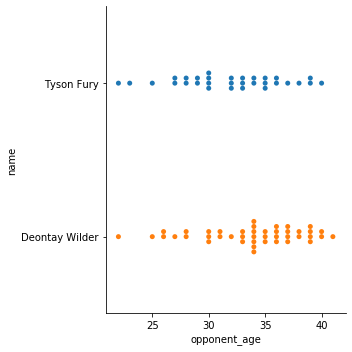

In [12]:
sns.catplot(x='opponent_age', y='name', data=df, kind='swarm')

In [13]:
df.groupby(['name', 'opponent_stance']).size().unstack('opponent_stance').rean

AttributeError: 'DataFrame' object has no attribute 'rean'

In [ ]:
pivot = (df.groupby(['name', 'opponent_stance']).size()
         .unstack('opponent_stance')
         .rename(columns=str.title)
        )
ax = sns.heatmap(pivot, linewidths=0.5, center=10, cmap="YlGnBu")
ax.set(xlabel='', ylabel='')
plt.show()
pivot

In [ ]:
sns.catplot(x="opponent_age", y="name", kind="bar", data=df)